In [ ]:
from datetime import datetime
import pickle

import gcsfs
import joblib
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
import pyspark.sql.types as T
import shap

shap.initjs()

fs = gcsfs.GCSFileSystem()

spark_conf = (
    SparkConf()
    .set('spark.driver.memory', '14g')
    .set('spark.executor.memory', '14g')
    .set('spark.driver.maxResultSize', '0')
    .set('spark.debug.maxToStringFields', '2000')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch', '500000')
    .set('spark.ui.showConsoleProgress', 'false')
)
spark = (
    SparkSession.builder.config(conf=spark_conf)
    .master('local[*]')
    .config("spark.driver.bindAddress", "127.0.0.1")
    .getOrCreate()
)


In [2]:

def load_model(bucket_name, file_name):
    with fs.open(f'{bucket_name}/{file_name}') as f:
        return joblib.load(f)

def save_shap_values(bucket_name, file_name, shap_values):
    with fs.open(f'{bucket_name}/{file_name}', 'wb') as f:
        pickle.dump(shap_values, f)

def load_shap_values(bucket_name, file_name):
    with fs.open(f'{bucket_name}/{file_name}', 'rb') as f:
        return pickle.load(f)


## 1. Preprocessing predictions to bring their feature matrix

To calculate the SHAP values I need to provide the feature metrix to the SHAP explainer class.
What I do here is:
1. Extract the highest scoring gene for each study/locus pair
2. Bring their feature matrix

In [3]:
window_highest_gene = Window.partitionBy('study_id', 'chrom', 'pos', 'ref', 'alt').orderBy(
         F.col('y_proba_full_model').desc()
)

predictions = (
    spark.read.parquet('data/predictions_2207').select('study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id', 'y_proba_full_model').distinct()
    # I want to interpret only the best scoring prediction
    .filter(F.col('y_proba_full_model') >= 0.05)
    .withColumn('best_scoring_pred_row_number', F.row_number().over(window_highest_gene))
    .filter(F.col('best_scoring_pred_row_number') == 1).drop('best_scoring_pred_row_number')

)

# Test. The highest scoring gene for this study/locus is SUGP1 (ENSG00000105705). That is what I get
predictions.filter(
    (F.col('chrom') == 19) & (F.col('pos') == 19296909) & (F.col('ref') == 'T') & (F.col('alt') == 'C') & (F.col('study_id') == 'GCST002222')
).orderBy(F.col('y_proba_full_model').desc()).show(5, False, True)



-RECORD 0--------------------------------
 study_id           | GCST002222         
 chrom              | 19                 
 pos                | 19296909           
 ref                | T                  
 alt                | C                  
 gene_id            | ENSG00000105705    
 y_proba_full_model | 0.5956910848617554 



In [4]:
# Join the features for each prediction

predictions_w_features = (
    predictions.join(
        spark.read.parquet('data/featurematrix_w_goldstandards.full.220712.parquet'),
        on=['study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id'], how='inner') # We have features for all predictions
    .distinct()
    .persist()
)

predictions_w_features.show(1, True, True)

22/07/28 17:20:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------------
 study_id                   | FINNGEN_R6_AD_U_E... 
 chrom                      | 19                   
 pos                        | 44908684             
 ref                        | T                    
 alt                        | C                    
 gene_id                    | ENSG00000130203      
 y_proba_full_model         | 0.6877729892730713   
 dhs_prmtr_max              | 0.9122129999999999   
 dhs_prmtr_max_nbh          | 1.0                  
 dhs_prmtr_ave              | 0.9116864415135244   
 dhs_prmtr_ave_nbh          | 1.0                  
 enhc_tss_max               | null                 
 enhc_tss_max_nbh           | null                 
 enhc_tss_ave               | null                 
 enhc_tss_ave_nbh           | null                 
 eqtl_coloc_llr_max         | null                 
 eqtl_coloc_llr_max_neglogp | null                 
 eqtl_coloc_llr_max_nbh     | null                 
 sqtl_coloc_

In [24]:
# At this point I should have the highest scoring gene for each study/locus.

assert (
    predictions_w_features.select('study_id', 'chrom', 'pos', 'ref', 'alt', 'gene_id').distinct().count()
    == predictions_w_features.select('study_id', 'chrom', 'pos', 'ref', 'alt').distinct().count()
), 'There is more than one gene for one prediction.'


## 2. Calculate the SHAP values



In [79]:
model_bucket = 'gs://genetics-portal-dev-staging/l2g/220712/models'
model_names = [f'xgboost-full_model-high_medium-{fold}.model.joblib.gz' for fold in range(5)]

models = [load_model(model_bucket, model_name) for model_name in model_names]
model_features = models[0]['run_info']['features']

[(model['run_info']['fold_num'], model['run_info']['fold_test_chroms']) for model in models]


[(0, {'1', '3', '8'}),
 (1, {'10', '16', '21', '22', '5', 'X'}),
 (2, {'11', '18', '20', '4', '9'}),
 (3, {'12', '17', '2', '7'}),
 (4, {'13', '14', '15', '19', '6'})]

In [124]:
'dist_tss_sentinel_nbh' in models[2]['run_info']['features']

False

In [129]:
today = datetime.now().strftime('%Y-%m-%d')

X = list()
output_bucket = f'gs://ot-team/irene/l2g_explainability/{today}'

for model in models:
    # Slice the feature matrix for this fold
    X_fold = predictions_w_features.filter(F.col('chrom').isin(model['run_info']['fold_test_chroms'])).toPandas()

    # Calculate the shap values for this fold
    explainer = shap.TreeExplainer(model['model'].best_estimator_)
    shap_values = explainer(X_fold.filter(items=model_features))
    assert (
        shap_values.shape == X_fold.filter(items=model_features).shape
    ), f'The shape of the SHAP values ({shap_values.shape}) does not match the shape of the feature matrix ({X_fold.filter(items=model_features).shape}).'

    # Save the shap values to GCS
    shap_values_filename = f'shap_values_{model["run_info"]["fold_num"]}.sav'
    save_shap_values(output_bucket, shap_values_filename, shap_values)

    # Store the metadata to retrieve the shap values later in the feature matrix
    X_fold['shap_values_filename'] = shap_values_filename
    X_fold['index'] = X_fold.index
    X_fold['explainer_expected_value'] = explainer.expected_value
    X_fold['model_fold'] = model['run_info']['fold_num']
    X_fold['model_fold_chroms'] = [list(model['run_info']['fold_test_chroms'])] * len(X_fold)

    X.append(X_fold)
    print(f'{len(X_fold)} rows in model #{model["run_info"]["fold_num"]}')



# assert len(X) == len(models), 'The number of models and the number of folds do not match.'

X = pd.concat(X, axis=0, ignore_index=True).astype({'pos': str}, errors='raise')
X.to_parquet(f'{output_bucket}/l2g_enriched_fm.parquet', index=False)
# X  = spark.createDataFrame(pd.concat(X, axis=0, ignore_index=True)).withColumn('pos', F.col('pos').cast(T.StringType()))
# X.write.parquet(f'{output_bucket}/feature_matrix')
# assert X.count() == predictions_w_features.count(), 'The original feature matrix and the feature matrix with shap values do not match in size.'


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


60467 rows in model #0
52238 rows in model #1
61906 rows in model #2
74060 rows in model #3
61511 rows in model #4


In [87]:
# Great! All shap values have been stored

fs.ls(output_bucket)

['ot-team/irene/l2g_explainability/2022-07-29/shap_values_0.sav',
 'ot-team/irene/l2g_explainability/2022-07-29/shap_values_1.sav',
 'ot-team/irene/l2g_explainability/2022-07-29/shap_values_2.sav',
 'ot-team/irene/l2g_explainability/2022-07-29/shap_values_3.sav',
 'ot-team/irene/l2g_explainability/2022-07-29/shap_values_4.sav']

In [130]:
# Example that shows how to retrieve the shap values


test = X.query("chrom == '1' & pos == '154839804' & ref == 'C' & alt == 'T' & study_id == 'FINNGEN_R6_I9_AF'")
print(test.drop(model_features, axis=1).iloc[0])

# The L2G prediction for KCNN3 is 0.76. Let's plot the force plot

shap_values = load_shap_values(output_bucket, 'shap_values_0.sav')
shap_index = test['index'].iloc[0]

shap.force_plot(
    base_value=test.explainer_expected_value.iloc[0],
    shap_values=shap_values[shap_index, :].values,
    features=test.query('index == 0').filter(items=model_features).iloc[0, :],
    link='logit',
)

# Where are the extra columns coming from? Sentinel related features that didn't end up in the model

study_id                     FINNGEN_R6_I9_AF
chrom                                       1
pos                                 154839804
ref                                         C
alt                                         T
gene_id                       ENSG00000143603
y_proba_full_model                   0.760369
dist_foot_sentinel                        0.0
dist_foot_sentinel_nbh                    0.0
dist_tss_sentinel                    10.32476
dist_tss_sentinel_nbh                     0.0
gs_confidence                            None
gs_set                                   None
gs_confidence_num                         NaN
gold_standard_status                      NaN
shap_values_filename        shap_values_0.sav
index                                       0
explainer_expected_value            -2.912217
model_fold                                  0
model_fold_chroms                   [3, 8, 1]
Name: 0, dtype: object


## 3. Plot feature importance for each model

In [142]:
import matplotlib.pyplot as plt

def save_summary_plot(shap_values: shap._explanation.Explanation, feature_matrix: pd.DataFrame, features: list):
    model_fold = feature_matrix['model_fold'].iloc[0]
    X = feature_matrix.filter(items=features)

    assert X.shape == shap_values.shape, f'The feature matrix and the shap values do not match in size ({X.shape} vs {shap_values.shape}).'

    fig = shap.summary_plot(shap_values, X, show=False)
    plt.title(f'Feature importance of model fold {model_fold}')
    plt.savefig(f'plots/summary_plot_fold_{model_fold}')
    plt.close()


In [146]:
# I have different sets of shap values that are the outcome of the different models

shap_values_lst = [load_shap_values(output_bucket, f'shap_values_{fold}.sav') for fold in range(5)]

for (fold, shap_set) in enumerate(shap_values_lst):

    shap_filename = f'shap_values_{fold}.sav'
    X_fold = X.query('shap_values_filename == @shap_filename').reset_index()

    print(f'Processing {shap_filename}...')
    save_summary_plot(
        shap_set,
        X_fold,
        features=model_features
    )

    #shap.summary_plot(shap_set, X_fold.filter(model_names), show=True)


Processing shap_values_0.sav...
Processing shap_values_1.sav...
Processing shap_values_2.sav...
Processing shap_values_3.sav...
Processing shap_values_4.sav...


In [139]:
X.query('shap_values_filename == @shap_filename').filter(items=model_features).shape

(52238, 53)

## 4. Plot feature importance for a given prediction

In [147]:
def find_prediction(feature_matrix: pd.DataFrame, variant: str, study_id: str):
    chrom, pos, ref, alt = variant.split('_')

    return feature_matrix.query('chrom == @chrom & pos == @pos & ref == @ref & alt == @alt & study_id == @study_id')

prediction = find_prediction(X, '1_154839804_C_T', 'FINNGEN_R6_I9_AF')

prediction.iloc[0]

study_id                     FINNGEN_R6_I9_AF
chrom                                       1
pos                                 154839804
ref                                         C
alt                                         T
                                  ...        
shap_values_filename        shap_values_0.sav
index                                       0
explainer_expected_value            -2.912217
model_fold                                  0
model_fold_chroms                   [3, 8, 1]
Name: 0, Length: 73, dtype: object

In [148]:
def plot_force_plot(shap_values: shap._explanation.Explanation, feature_matrix: pd.DataFrame, features: list):

    shap_value_index = feature_matrix['index'].iloc[0]
    base_value = feature_matrix['explainer_expected_value'].iloc[0]

    fig = shap.force_plot(
        base_value=base_value,
        shap_values=shap_values[shap_value_index, :].values,
        features=feature_matrix.filter(items=features),
        link='logit',
    )
    plt.show()


shap_values = shap_values_lst[prediction['model_fold'].iloc[0]]

plot_force_plot(shap_values, prediction, model_features)


In [149]:
shap.force_plot(
    base_value=prediction['explainer_expected_value'].iloc[0],
    shap_values=shap_values[prediction['index'].iloc[0], :].values,
    features=prediction.filter(items=model_features),
    link='logit',
    show=True,
)

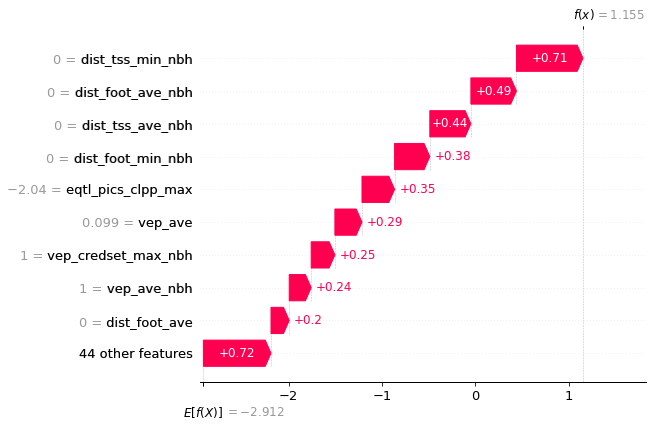

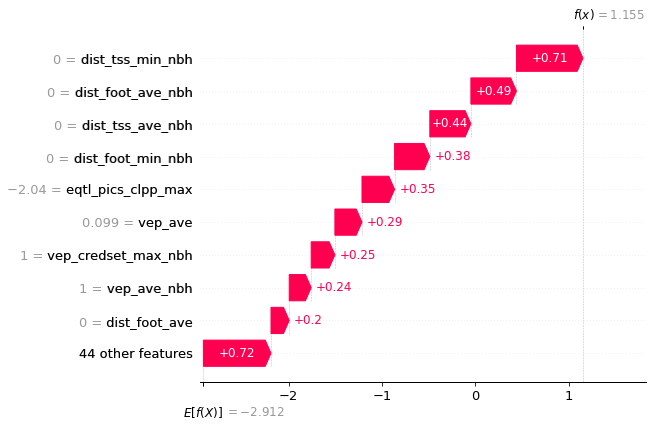

In [158]:
(
        shap.plots.waterfall(
            shap_values[prediction['index'].iloc[0]],
            max_display=10,
            show=False
        )
    )